In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams 
from scipy import stats
import scipy
from scipy.stats import pearsonr
import numpy as np
from scipy.stats import linregress
rcParams['pdf.fonttype'] = 42 # True font
rcParams['font.size'] =  8  
rcParams['grid.linewidth'] =  0.5 
rcParams['lines.color'] = 'b' 
rcParams['lines.linewidth'] = 1 
rcParams['lines.markersize'] = 3
rcParams['lines.markeredgewidth'] = 0 # set Marker with no edgelines
rcParams['axes.linewidth'] = 0.5
rcParams['axes.titlesize'] = 8
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 8
rcParams['legend.title_fontsize'] = 8

In [25]:
# Allele_specific genes
Rawdir="/data2/linzhuobin/Hap3D_Figures/figure_processing_data/Fig6"
outdir="/data2/linzhuobin/Hap3D_Figures/pdf"
filename = f"{Rawdir}/pre_data/Allele_specific_genes.txt"
AS_genes_df = pd.read_csv(filename, header=0, index_col=None, sep="\t")
AS_genes = AS_genes_df["Gene ID"].to_list()

file_path = f"{Rawdir}/pre_data/imprinted.xlsx"  # imprinted genes
imprinted_df = pd.read_excel(file_path)

P = ( imprinted_df["Expressed allele"]=="Maternal" ) | (  imprinted_df["Expressed allele"]=="Paternal" )
imprinted_df = imprinted_df.loc[P, :]
imprinted_genes = imprinted_df['Gene ID'].tolist()

In [26]:
# chrX ESVE
file_path = f'{Rawdir}/pre_data/chrx_E_S_VE.xlsx' # ES genes
chrx_E_S_VE = pd.read_excel(file_path,header = None,
                           names = ['Genename', 'Type'])
chrx_E_S_VE.replace(np.nan, 'Other', inplace = True)
chrx_E_S_VE.replace("PAR", 'Other', inplace = True)
chrx_E_S_VE.replace("Mostly S", 'S', inplace = True)
chrx_E_S_VE.replace("Mostly E", 'E', inplace = True)
chrx_E_S_VE.replace("Mostly VE", 'VE', inplace = True)
chrx_E_S_VE = chrx_E_S_VE.set_index("Genename")["Type"].to_dict()

file_path = f'{Rawdir}/pre_data/chrx_E_S_ES_ENSG.txt'
ESVE_df = pd.read_csv(file_path, sep="\t", 
                        header=None, index_col=None, names=["Genename", "ENSG", "ID"] )
ESVE_df["Type"] = "Other"
ESVE_df["Type"] = ESVE_df["Genename"].apply(lambda x: chrx_E_S_VE[x] )
ESVE_df["Chromosome"] = "chrX"
S_genes = ESVE_df.loc[ESVE_df.Type=="S", "ENSG"].to_list()
E_genes = ESVE_df.loc[ESVE_df.Type=="E", "ENSG"].to_list()
VE_genes = ESVE_df.loc[ESVE_df.Type=="VE", "ENSG"].to_list()

In [53]:
# filter readcount >= 5
thred = 5

filename_M = f'{Rawdir}/pre_data/MER_all.txt'#genes
result_M = pd.read_csv(filename_M, header=0,  sep="\t")
result_M["h1_rc"] = result_M["ME_hp1"] + result_M["NE_hp1"] + result_M["SE_hp1"]
result_M["h2_rc"] = result_M["ME_hp2"] + result_M["NE_hp2"] + result_M["SE_hp2"]
P_M = (result_M["h1_rc"]>=thred)&(result_M["h2_rc"] >= thred)
result_M = result_M.loc[P_M, :]

filename_D = f'{Rawdir}/pre_data/DLR_all.txt' #genes
result_D = pd.read_csv(filename_D, header=0,  sep="\t")
#result_D["DLR_difference"] = (result_D["h1_mean"] - result_D["h2_mean"]).abs()
P_D = (result_D["h1_nobs"]>=thred)&(result_D["h2_nobs"] >= thred)
result_D = result_D.loc[P_D, :]

In [54]:
# HP1 and HP2 and theri corresbonding Maternal and Paternal

# HP1 = Maternal, HP2 = Paternal;
H1mH2p=["chr11","chr12","chr13","chr14","chr15", "chr18", "chr21", "chr22", "chr3", "chr7", "chr8", "chrX"] 
# HP1 = Paternal, HP2 = Maternal;
H1pH2m=["chr1", "chr10", "chr16", "chr17", "chr19", "chr2", "chr20", "chr4", "chr5", "chr6", "chr9"] 


df1_M = result_M.loc[result_M.chrom.isin(H1mH2p),
       ["chrom","PID", "ME_ratio_hp1",  "ME_ratio_hp2"]  ]
df1_M.columns = ["chrom","index", "ma_mean", "pa_mean"]

df2_M = result_M.loc[result_M.chrom.isin(H1pH2m),
       ["chrom","PID", "ME_ratio_hp2", "ME_ratio_hp1"]  ]
df2_M.columns = ["chrom","index", "ma_mean", "pa_mean"]

result_M = pd.concat([df1_M, df2_M], axis=0)
result_M = result_M.dropna()
result_M["diff_MER"] = ( result_M["ma_mean"] - result_M["pa_mean"] ).abs()

df1_D = result_D.loc[result_D.chrom.isin(H1mH2p),
       ["chrom","index", "h1_mean", "h1_std", "h1_nobs", "h2_mean", "h2_std", "h2_nobs", "pvalue", "adjpval"]  ]
df1_D.columns = ["chrom","index", "ma_mean", "ma_std", "ma_nobs", "pa_mean", "pa_std", "pa_nobs", "pvalue", "adjpval"]

df2_D = result_D.loc[result_D.chrom.isin(H1pH2m),
       ["chrom","index", "h2_mean", "h2_std", "h2_nobs", "h1_mean", "h1_std", "h1_nobs","pvalue", "adjpval"]  ]
df2_D.columns = ["chrom","index", "ma_mean", "ma_std", "ma_nobs", "pa_mean", "pa_std", "pa_nobs", "pvalue", "adjpval"]

result_D = pd.concat([df1_D, df2_D], axis=0)
result_D["diff_SDPR"] = ( result_D["ma_mean"] - result_D["pa_mean"] ).abs()

In [29]:
def stat_pvalue(xdata,ydata):
    stat, p_value = scipy.stats.ttest_ind(xdata,ydata,equal_var=False)
    return(p_value)

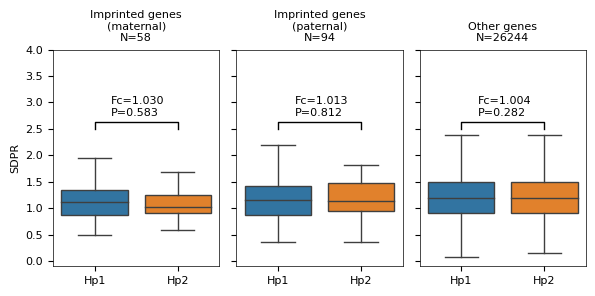

In [30]:
#Autosome imprinted genes
autosome = result_D.loc[ result_D.chrom != "chrX"].copy()
# Autosome plot
im_mgenes = imprinted_df.loc[(imprinted_df.Chromosome != "chrX")&(imprinted_df["Expressed allele"] == "Maternal"), "Gene ID"]
im_pgenes = imprinted_df.loc[(imprinted_df.Chromosome != "chrX")&(imprinted_df["Expressed allele"] == "Paternal"), "Gene ID"]

AS_imp = list(im_mgenes)
AS_imp.extend(im_pgenes)
AS_imp = list(set(AS_imp))
other_genes = autosome.loc[~autosome["index"].isin(AS_imp), "index"].to_list()
GeneList = [im_mgenes, im_pgenes, other_genes]

Samplelist = [ f"Imprinted genes\n(maternal)", f"Imprinted genes\n(paternal)",
            f"Other genes" ]

num_groups = len(Samplelist)
cols = 3
rows = int(  num_groups// cols )
fig, axs = plt.subplots(rows, cols, figsize=(6, 3), sharey=True)
axs = axs.flatten()
n = 0

for genes, sID in zip( GeneList, Samplelist ):
    #genes, sID = GeneList[0], Samplelist[0]
    v1 = autosome.loc[autosome["index"].isin(genes), "ma_mean"].values
    v2 = autosome.loc[autosome["index"].isin(genes), "pa_mean"].values
    boxdata = pd.DataFrame({"Value": list(v1) + list(v2) ,
                           "Hap": len(v1)*[f'Hp1']+len(v2)*[f'Hp2'] })
    pval = stat_pvalue(v1, v2)
    sns.boxplot(x='Hap', 
                y='Value', 
                data=boxdata,
               showfliers = False,
                ax=axs[n])

    ## fold chagne and p_value
    x1, x2 = 0, 1
    y = 2.5
    h = y*0.05
    FC = np.mean(v1)/np.mean(v2)
    axs[n].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k")
    axs[n].text((x1+x2)/2-0.3 ,y+2*h,f"Fc={FC:.3f}\nP={pval:.3f}")
    axs[n].set_ylim([-0.1, 4])
    if n == 0:
        axs[n].set_ylabel("SDPR")
    else:
        axs[n].set_ylabel("")
    axs[n].set_xlabel("")
    axs[n].set_title(f"{sID}\nN={len(v1)}")
    n += 1
plt.tight_layout()
plt.savefig(f"{outdir}/autosome_SDPR.pdf")
plt.show()

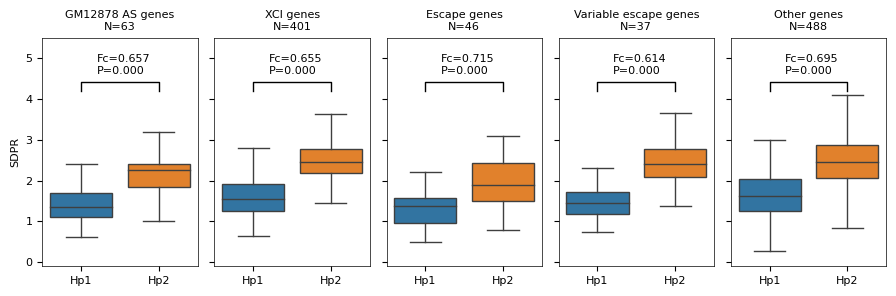

In [31]:
#chrX
chrX_df = result_D.loc[ result_D.chrom == "chrX"].copy()

AS_mgenes = AS_genes_df.loc[(AS_genes_df.Chromosome == "chrX")
                            &(AS_genes_df["Expressed allele"] == "Maternal"), "Gene ID"]

AE=[]
AE.extend(S_genes)
AE.extend(E_genes)
AE.extend(VE_genes)
other_genes = chrX_df.loc[~chrX_df["index"].isin(AE), "index"].to_list()


GeneList = [AS_mgenes, S_genes, E_genes, VE_genes, other_genes]

Samplelist = [f"GM12878 AS genes", f"XCI genes", 
            f"Escape genes", f"Variable escape genes",
            f"Other genes" ]

num_groups = len(Samplelist)
cols = 5
rows = int(  num_groups// cols )
fig, axs = plt.subplots(rows, cols, figsize=(9, 3), sharey=True)
axs = axs.flatten()
n = 0

for genes, sID in zip( GeneList, Samplelist ):
    #genes, sID = GeneList[0], Samplelist[0]
    v1 = chrX_df.loc[chrX_df["index"].isin(genes), "ma_mean"].values
    v2 = chrX_df.loc[chrX_df["index"].isin(genes), "pa_mean"].values
    boxdata = pd.DataFrame({"Value": list(v1) + list(v2) ,
                           "Hap": len(v1)*[f'Hp1']+len(v2)*[f'Hp2'] })
    pval = stat_pvalue(v1, v2)
    sns.boxplot(x='Hap', 
                y='Value', 
                data=boxdata,
               showfliers = False,
                ax=axs[n])

    ## fold chagne and p_value
    x1, x2 = 0, 1
    y = 4.2
    h = y*0.05
    FC = np.mean(v1)/np.mean(v2)
    axs[n].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k")
    axs[n].text((x1+x2)/2-0.3 ,y+2*h,f"Fc={FC:.3f}\nP={pval:.3f}")
    axs[n].set_ylim([-0.1, 5.5])
    if n == 0:
        axs[n].set_ylabel("SDPR")
    else:
        axs[n].set_ylabel("")
    axs[n].set_xlabel("")
    axs[n].set_title(f"{sID}\nN={len(v1)}")
    n += 1
plt.tight_layout()
plt.savefig(f"{Rawdir}/chrX_SDPR.pdf")
plt.show()

Kruskal-Wallis H p_value：4.4e-206
auto_imprinted vs other_auto：p = 9.744e-01
auto_imprinted vs XCI：p = 8.071e-61
auto_imprinted vs Escape：p = 4.023e-11
other_auto vs XCI：p = 1.267e-207
other_auto vs Escape：p = 7.574e-14
XCI vs Escape：p = 2.645e-06


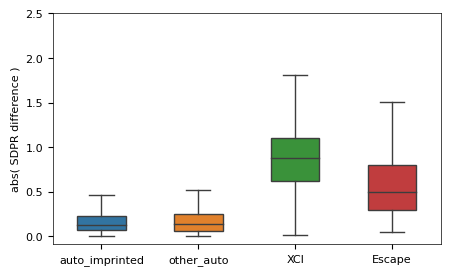

In [47]:
# SDPR Difference comparison
genelist = {"auto_imprinted" :  AS_imp,
            "other_auto" : autosome.loc[~autosome["index"].isin(AS_imp), "index"].to_list(),
            "XCI" : S_genes,
            "Escape" : E_genes}
plotlist = []
val_list,key_list = [], []
for key, genes in genelist.items():
    diff_values = result_D.loc[result_D["index"].isin(genes), "diff_SDPR"].values
    pdf = pd.DataFrame({"Group": len(diff_values)*[key],
                        "diff": diff_values })
    plotlist.append(pdf)
    
    key_list.append(key)
    val_list.append(diff_values)
plotdata = pd.concat(plotlist)

# 
import scipy.stats as stats
from itertools import combinations

result = stats.kruskal( val_list[0], val_list[1], val_list[2] )
kpval = result.pvalue
print(f"Kruskal-Wallis H p_value：{kpval :.1e}")
if kpval  < 0.05:
    comb = combinations(val_list, 2)
    keycomb = combinations(key_list, 2)
    for keys, vals in zip( keycomb, comb ):
        U, p_value = stats.mannwhitneyu(vals[0], vals[1])
        print(f"{keys[0]} vs {keys[1]}：p = {p_value:.3e}")
        
    
# plot
plt.figure(figsize=(5,3))
sns.boxplot(x="Group", y="diff", data=plotdata, showfliers=False, width=0.5)
#sns.boxplot(x="Group", y="diff", data=plotdata, showfliers=False, width=0.5)
plt.yticks(np.linspace(0,2.5,6) )
plt.ylabel('abs( SDPR difference )')
plt.xlabel('')
plt.savefig(f"{outdir}/SDPR_difference.pdf")
#plt.show()

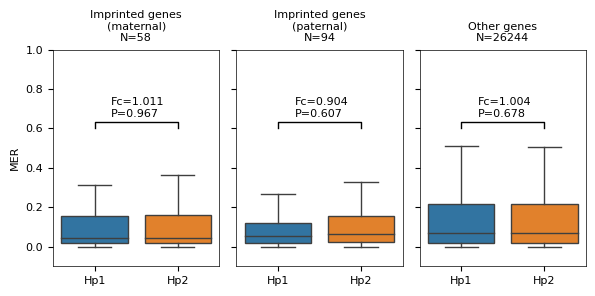

In [56]:
# Autosome plot
autosome = result_M.loc[ result_M.chrom != "chrX"].copy()
# Autosome plot
im_mgenes = imprinted_df.loc[(imprinted_df.Chromosome != "chrX")&(imprinted_df["Expressed allele"] == "Maternal"), "Gene ID"]
im_pgenes = imprinted_df.loc[(imprinted_df.Chromosome != "chrX")&(imprinted_df["Expressed allele"] == "Paternal"), "Gene ID"]

AS_imp = list(im_mgenes)
AS_imp.extend(im_pgenes)
AS_imp = list(set(AS_imp))
other_genes = autosome.loc[~autosome["index"].isin(AS_imp), "index"].to_list()
GeneList = [im_mgenes, im_pgenes, other_genes]

Samplelist = [ f"Imprinted genes\n(maternal)", f"Imprinted genes\n(paternal)",
            f"Other genes" ]

num_groups = len(Samplelist)
cols = 3
rows = int(  num_groups// cols )
fig, axs = plt.subplots(rows, cols, figsize=(6, 3), sharey=True)
axs = axs.flatten()
n = 0

for genes, sID in zip( GeneList, Samplelist ):
    #genes, sID = GeneList[0], Samplelist[0]
    v1 = autosome.loc[autosome["index"].isin(genes), "ma_mean"].values
    v2 = autosome.loc[autosome["index"].isin(genes), "pa_mean"].values
    boxdata = pd.DataFrame({"Value": list(v1) + list(v2) ,
                           "Hap": len(v1)*[f'Hp1']+len(v2)*[f'Hp2'] })
    pval = stat_pvalue(v1, v2)
    sns.boxplot(x='Hap', 
                y='Value', 
                data=boxdata,
               showfliers = False,
                ax=axs[n])

    ## fold chagne and p_value
    x1, x2 = 0, 1
    y = 0.6
    h = y*0.05
    FC = np.mean(v1)/np.mean(v2)
    axs[n].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k")
    axs[n].text((x1+x2)/2-0.3 ,y+2*h,f"Fc={FC:.3f}\nP={pval:.3f}")
    axs[n].set_ylim([-0.1, 1])
    if n == 0:
        axs[n].set_ylabel("MER")
    else:
        axs[n].set_ylabel("")
    axs[n].set_xlabel("")
    axs[n].set_title(f"{sID}\nN={len(v1)}")
    n += 1
plt.tight_layout()
plt.savefig(f"{outdir}/autosome_MRE_v1.pdf")
plt.show()

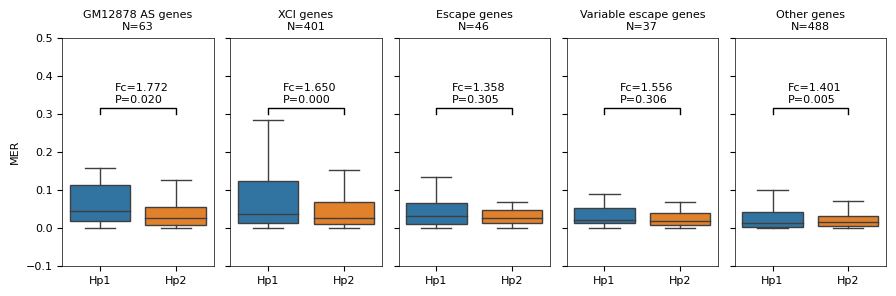

In [57]:
#chrX
chrX_df = result_M.loc[ result_M.chrom == "chrX"].copy()

AS_mgenes = AS_genes_df.loc[(AS_genes_df.Chromosome == "chrX")&(AS_genes_df["Expressed allele"] == "Maternal"), "Gene ID"]
#AE = list(AS_genes)
AE=[]
AE.extend(S_genes)
AE.extend(E_genes)
AE.extend(VE_genes)
other_genes = chrX_df.loc[~chrX_df["index"].isin(AE), "index"].to_list()


GeneList = [AS_mgenes, S_genes, E_genes, VE_genes, other_genes]

Samplelist = [f"GM12878 AS genes", f"XCI genes", 
            f"Escape genes", f"Variable escape genes",
            f"Other genes" ]

num_groups = len(Samplelist)
cols = 5
rows = int(  num_groups// cols )
fig, axs = plt.subplots(rows, cols, figsize=(9, 3), sharey=True)
axs = axs.flatten()
n = 0

for genes, sID in zip( GeneList, Samplelist ):
    #genes, sID = GeneList[0], Samplelist[0]
    v1 = chrX_df.loc[chrX_df["index"].isin(genes), "ma_mean"].values
    v2 = chrX_df.loc[chrX_df["index"].isin(genes), "pa_mean"].values
    boxdata = pd.DataFrame({"Value": list(v1) + list(v2) ,
                           "Hap": len(v1)*[f'Hp1']+len(v2)*[f'Hp2'] })
    pval = stat_pvalue(v1, v2)
    sns.boxplot(x='Hap', 
                y='Value', 
                data=boxdata,
               showfliers = False,
                ax=axs[n])

    ## fold chagne and p_value
    x1, x2 = 0, 1
    y = 0.3
    h = y*0.05
    FC = np.mean(v1)/np.mean(v2)
    axs[n].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k")
    axs[n].text((x1+x2)/2-0.3 ,y+2*h,f"Fc={FC:.3f}\nP={pval:.3f}")
    axs[n].set_ylim([-0.1, 0.5])
    if n == 0:
        axs[n].set_ylabel("MER")
    else:
        axs[n].set_ylabel("")
    axs[n].set_xlabel("")
    axs[n].set_title(f"{sID}\nN={len(v1)}")
    n += 1
plt.tight_layout()
plt.savefig(f"{outdir}/chrX_MER.pdf")
plt.show()

Kruskal-Wallis H p_value：1.1e-09
auto_imprinted vs other_auto：p = 2.836e-01
auto_imprinted vs XCI：p = 1.088e-02
auto_imprinted vs Escape：p = 5.135e-01
other_auto vs XCI：p = 2.226e-10
other_auto vs Escape：p = 1.710e-01
XCI vs Escape：p = 3.228e-01


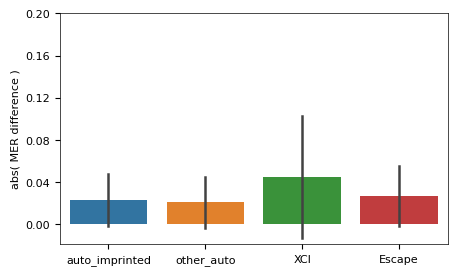

In [74]:
genelist = {"auto_imprinted" :  AS_imp,
            "other_auto" : autosome.loc[~autosome["index"].isin(AS_imp), "index"].to_list(),
            "XCI" : S_genes,
            "Escape" : E_genes}
plotlist = []
val_list,key_list = [], []
for key, genes in genelist.items():
    diff_values = result_M.loc[result_M["index"].isin(genes), "diff_MER"].values
    pdf = pd.DataFrame({"Group": len(diff_values)*[key],
                        "diff": diff_values })
    plotlist.append(pdf)
    
    key_list.append(key)
    val_list.append(diff_values)
plotdata = pd.concat(plotlist)

# 
import scipy.stats as stats
from itertools import combinations

result = stats.kruskal( val_list[0], val_list[1], val_list[2] )
kpval = result.pvalue
print(f"Kruskal-Wallis H p_value：{kpval :.1e}")
if kpval  < 0.05:
    comb = combinations(val_list, 2)
    keycomb = combinations(key_list, 2)
    for keys, vals in zip( keycomb, comb ):
        U, p_value = stats.mannwhitneyu(vals[0], vals[1])
        print(f"{keys[0]} vs {keys[1]}：p = {p_value:.3e}")
        
    
# plot
plt.figure(figsize=(5,3))
#sns.boxplot(x="Group", y="diff", data=plotdata, showfliers=False, width=0.5)
sns.barplot(x="Group", y="diff", data=plotdata, ci="sd")
plt.yticks(np.linspace(0,0.2,6) )
plt.ylabel('abs( MER difference )')
plt.xlabel('')
plt.savefig(f"{outdir}/MER_difference.pdf")
#plt.show()

In [11]:
# RNA seq
## DLR 
result_D["DLR"] = ((result_D["ma_mean"].values 
                    * result_D["ma_nobs"].values  
                    + result_D["pa_mean"].values 
                    * result_D["pa_nobs"].values ) 
                   / ( result_D["ma_nobs"] + result_D["pa_nobs"] ))  
## RNA expression
RNAseqfile = f"{Rawdir}/pre_data/GM12878_TPM.csv"
RNAdf = pd.read_csv(RNAseqfile, sep="\t", header=0, index_col=0)
RNAdf["RNAval"] =  RNAdf.loc[:, ["GM12878_A1", "GM12878_A2","GM12878_B1","GM12878_B2"] ].mean(axis=1).values
RNAdf["Level"] =0
RNAdf.index = RNAdf.index.str.split(".").str[0]
# high, mid, low, top 1%, 75-99%, 75%
high_val, mid_val = RNAdf.loc[RNAdf.RNAval>0, "RNAval"].quantile(0.99), RNAdf.loc[RNAdf.RNAval>0, "RNAval"].quantile(0.75)
RNAdf.loc[RNAdf.RNAval>high_val, "Level"] = 3 # high
RNAdf.loc[RNAdf.RNAval<mid_val, "Level"] = 1 # low
RNAdf.loc[(RNAdf.RNAval>=mid_val)&(RNAdf.RNAval<=high_val), "Level"] = 2 # Middle
RNAdf.loc[RNAdf.RNAval==0, "Level"] = 0 # None

PID = result_D["index"].values
values = result_D.DLR.values
RNAdf = RNAdf.loc[PID].reset_index()
RNAdf = RNAdf.drop_duplicates(subset='gene_id')
RNAdf = RNAdf.set_index('gene_id')
Corr_df = pd.DataFrame( { "PID" : PID,
                          "RNAval": RNAdf.loc[PID, "RNAval"],
                          "Level" : RNAdf.loc[PID, "Level"],
                         "values" : values } )

-0.11067517667878456 2.508900760356463e-75


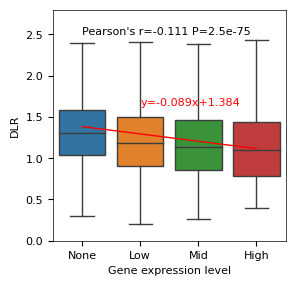

In [12]:
corr, p = pearsonr( Corr_df["Level"].values, Corr_df["values"].values ) 
print(corr, p)
plt.figure(figsize=(3,3))
sns.boxplot(x="Level", y="values", data=Corr_df, showfliers=False)
plt.xticks([0,1,2,3], ["None", "Low", "Mid", "High"], fontsize=8)
meanval = [np.mean(Corr_df.loc[Corr_df["Level"]==n, "values"].values) for n in [0,1,2,3] ]
slope, intercept, r,p , std_err = linregress(  Corr_df["Level"].values, Corr_df["values"].values )
plt.plot(  np.array([0,1,2,3]), intercept + slope*np.array([0,1,2,3]), color="r" )
plt.text(x=1, y=1.5, s = f"y={slope:.3f}x+{intercept:.3f}\n",color="r", fontsize=8)
plt.text(x=0, y=2.5, s=f"Pearson's r={corr:.3f} P={p:.1e}", color="k")
plt.ylim([0, 2.8])
# Add title and axes labels
plt.ylabel('DLR')
plt.xlabel('Gene expression level')
plt.savefig(f"{outdir}/DLR_gene_expression.pdf")
plt.show()

In [13]:
result = pd.read_csv(f"{Rawdir}/pre_data/MER_all.txt",
                    sep="\t")
# filter readcount >= 5
thred = 5
result["h1_rc"] = result["ME_hp1"] + result["NE_hp1"] + result["SE_hp1"]
result["h2_rc"] = result["ME_hp2"] + result["NE_hp2"] + result["SE_hp2"]
P = (result["h1_rc"]>=thred)&(result["h2_rc"] >= thred)
result = result.loc[P, :]

In [14]:
result["hp1_count"] =  result["ME_hp1"].values + result["NE_hp1"].values + result["SE_hp1"].values 
result["hp2_count"] =  result["ME_hp2"].values + result["NE_hp2"].values + result["SE_hp2"].values 
result["count"] = result["hp1_count"] + result["hp2_count"]
result["ME_ratio"] = (result["ME_hp1"].values + result["ME_hp2"].values)  /  result["count"].values
result["SE_ratio"] = (result["SE_hp1"].values + result["SE_hp2"].values)  /  result["count"].values
result["Ecount_mean"] =  (result["hp1_count"].values * result["Ecount_mean_hp1"].values  + result["hp2_count"].values * result["Ecount_mean_hp2"].values ) / ( result["hp1_count"] + result["hp2_count"] )  

PID = result.PID.values
Corr_df = pd.DataFrame( { "PID" : PID,
                          "RNAval": RNAdf.loc[PID, "RNAval"],
                          "Level" : RNAdf.loc[PID, "Level"],
                         "Evalues" : result.Ecount_mean.values,
                         "MEratio": result.ME_ratio.values,
                         "SEratio": result.SE_ratio.values} )
Corr_df.head()

,PID,RNAval,Level,Evalues,MEratio,SEratio
gene_id,,,,,,
ENSG00000000457,ENSG00000000457,9.6500,1,0.512821,0.085470,0.330484
ENSG00000000460,ENSG00000000460,20.5525,2,0.269841,0.045351,0.172336
ENSG00000000938,ENSG00000000938,104.0750,2,1.177835,0.322165,0.345361
ENSG00000000971,ENSG00000000971,0.0150,1,0.077320,0.005155,0.067010
ENSG00000001460,ENSG00000001460,0.7775,1,0.473973,0.106849,0.235616


0.45275025049005113 0.0


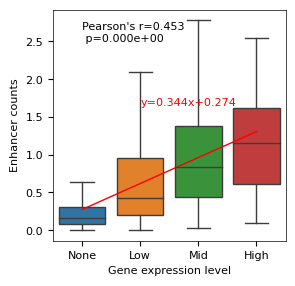

In [15]:
corr, p = pearsonr( Corr_df["Level"].values, Corr_df["Evalues"].values ) 
print(corr, p)
plt.figure(figsize=(3,3))
sns.boxplot(x="Level", y="Evalues", data=Corr_df, showfliers=False)
plt.xticks([0,1,2,3], ["None", "Low", "Mid", "High"], fontsize=8)
meanval = [np.mean(Corr_df.loc[Corr_df["Level"]==n, "Evalues"].values) for n in [0,1,2,3] ]
slope, intercept, r,p , std_err = linregress(  Corr_df["Level"].values, Corr_df["Evalues"].values )
plt.plot(  np.array([0,1,2,3]), intercept + slope*np.array([0,1,2,3]), color="r" )
plt.text(x=1, y=1.5, s = f"y={slope:.3f}x+{intercept:.3f}\n",color="r", fontsize=8)
plt.text(x=0, y=2.5, s=f"Pearson's r={corr:.3f}\n p={p:.3e}", color="k")
# Add title and axes labels
plt.ylabel('Enhancer counts')
plt.xlabel('Gene expression level')
plt.savefig(f"{outdir}/Enhancer_counts_gene_expression.pdf")
plt.show()

0.40510213009517765 0.0


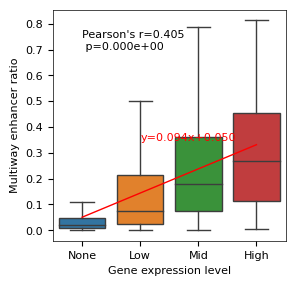

In [16]:
corr, p = pearsonr( Corr_df["Level"].values, Corr_df["MEratio"].values ) 
print(corr, p)
plt.figure(figsize=(3,3))
sns.boxplot(x="Level", y="MEratio", data=Corr_df, showfliers=False)
plt.xticks([0,1,2,3], ["None", "Low", "Mid", "High"], fontsize=8)
meanval = [np.mean(Corr_df.loc[Corr_df["Level"]==n, "MEratio"].values) for n in [0,1,2,3] ]
slope, intercept, r,p , std_err = linregress(  Corr_df["Level"].values, Corr_df["MEratio"].values )
plt.plot(  np.array([0,1,2,3]), intercept + slope*np.array([0,1,2,3]), color="r" )
plt.text(x=1, y=0.3, s = f"y={slope:.3f}x+{intercept:.3f}\n",color="r", fontsize=8)
plt.text(x=0, y=0.7, s=f"Pearson's r={corr:.3f}\n p={p:.3e}", color="k")
# Add title and axes labels
plt.ylabel('Multiway enhancer ratio')
plt.xlabel('Gene expression level')
plt.savefig(f"{outdir}/pre_data/ME_ratio_gene_expression.pdf")
plt.show()